- BMI 예제

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

label     0
height    0
weight    0
dtype: int64


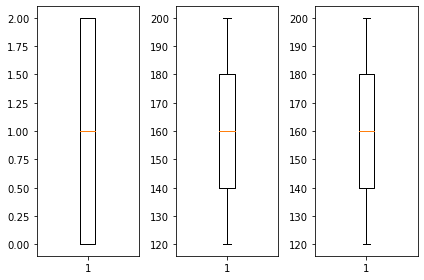

In [2]:
df = pd.read_csv('../data/bmi/bmi.csv', skiprows=3)

# 결측치 확인
print(df.isnull().sum())

# 이상치 확인fat
fig = plt.figure()

fig_1 = fig.add_subplot(1,3,1)
fig_2 = fig.add_subplot(1,3,2)
fig_3 = fig.add_subplot(1,3,3)

fig_1.boxplot(df['label'])
fig_2.boxplot(df['height'])
fig_3.boxplot(df['height'])

fig.tight_layout()
plt.show() # 이상치 없음

In [3]:
# training, test data set
x_data_train, x_data_test, t_data_train, t_data_test = \
train_test_split(df[['height', 'weight']],df['label'], 
                 test_size=0.3, random_state=0)

# 정규화
scaler = MinMaxScaler()
scaler.fit(x_data_train)
x_data_train_norm = scaler.transform(x_data_train)
x_data_test_norm = scaler.transform(x_data_test)

# 혼동을 줄이기 위해 변수 삭제
del x_data_train
del x_data_test

# One-Hot Encoding with tensorflow
sess = tf.Session()
t_data_train_onehot = sess.run(tf.one_hot(t_data_train, depth=3))
t_data_test_onehot = sess.run(tf.one_hot(t_data_test, depth=3))

del t_data_train
del t_data_test

In [6]:
# placeholder
X = tf.placeholder(shape=[None,2], dtype=tf.float32)
T = tf.placeholder(shape=[None,3], dtype=tf.float32)

# Weight & bias
W = tf.Variable(tf.random.normal([2,3]), name='weight')
b = tf.Variable(tf.random.normal([3]), name='bias')

# Hypothesis
logit = tf.matmul(X,W) + b
H = tf.nn.softmax(logit)

# loss function
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logit,
                                                                 labels=T))

# train
train = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)

# 초기화
sess.run(tf.global_variables_initializer())

In [7]:
# trianing과 validatiaon 분리해서 학습진행
cv = 3
acc_list = []

kf = KFold(n_splits=cv, shuffle=True)

for train_idx, val_idx in kf.split(x_data_train_norm):
    training_x = x_data_train_norm[train_idx]
    training_t = t_data_train_onehot[train_idx]
    
    val_x = x_data_train_norm[val_idx]
    val_t = t_data_train_onehot[val_idx]
    
    # learning
    for step in range(10000):
        _, loss_val = sess.run([train,loss], 
                               feed_dict={X : training_x, T : training_t })

        if step % 5000 == 0:
            print('loss:{}'.format(loss_val))
    
    # prediction
    result = sess.run(H, feed_dict={X: val_x})
    accuracy_list = np.equal(result.argmax(axis=1), val_t.argmax(axis=1))
    acc_list.append(accuracy_list.sum()/len(accuracy_list))
    
    print('학습 결과 : {}'.format(accuracy_list.sum()/len(accuracy_list)))
    
acc_list = np.array(acc_list)
print('최종 Accuracy : {}'.format(acc_list .mean()))

loss:1.34272301197052
loss:0.30207139253616333
학습 결과 : 0.9796443111206342
loss:0.23830866813659668
loss:0.20567791163921356
학습 결과 : 0.9820012856224556
loss:0.18480150401592255
loss:0.1705883890390396
학습 결과 : 0.9783540505786541
최종 Accuracy : 0.9799998824405813


In [8]:
result_pred = sess.run(H, feed_dict={X: x_data_test_norm})
pred_list = np.equal(result_pred.argmax(axis=1), t_data_test_onehot.argmax(axis=1))

print('학습 결과 : {}'.format(pred_list.sum()/len(pred_list)))

학습 결과 : 0.9841666666666666


- [argmax()](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html#numpy.argmax): 최대값의 index 반환
- [equal()](https://numpy.org/doc/stable/reference/generated/numpy.equal.html?highlight=equal) : ndarray 비교
- [array_split()](https://numpy.org/doc/stable/reference/generated/numpy.array_split.html#numpy.array_split) : ndarray 분할